In [2]:
# %matplotlib inline
%config InlineBackend.figure_format = "retina"

In [3]:
import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# feel free to modify, for example, change the context to "notebook"
sns.set_theme(context="talk", style="whitegrid",
              palette="colorblind", color_codes=True,
              rc={"figure.figsize": [14, 6]})

The Breeden-Litzenberger formula is used to estimate risk-neutral probability density functions (PDFs) from option prices. It's based on the idea that you can infer the risk-neutral PDF from the prices of European call and put options with different strikes and maturities.

In [5]:
import numpy as np
import scipy as sc
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(14,6)
plt.style.use('dark_background')

European Call Option with Stochastic Volatility

In [6]:
# Initialise parameters
S0 = 100.0     # initial stock price
K = 150.0      # strike price
tau = 1.0        # time to maturity in years
r = 0.06       # annual risk-free rate
# Heston dependent parameters
kappa = 3              # rate of mean reversion of variance under risk-neutral dynamics
theta = 0.20**2        # long-term mean of variance under risk-neutral dynamics
v0 = 0.20**2           # initial variance under risk-neutral dynamics
rho = 0.98              # correlation between returns and variances under risk-neutral dynamics
sigma = 0.2            # volatility of volatility
lambd = 0              # risk premium of variance
2*kappa*theta, ' > ',sigma**2

(0.24000000000000005, ' > ', 0.04000000000000001)

In [7]:
def heston_charfunc(phi, S0, v0, kappa, theta, sigma, rho, lambd, tau, r):
    
    # constants
    a = kappa*theta
    b = kappa+lambd
    
    # common terms w.r.t phi
    rspi = rho*sigma*phi*1j
    
    # define d parameter given phi and b
    d = np.sqrt( (rspi - b)**2 + (phi*1j+phi**2)*sigma**2 )
    
    # define g parameter given phi, b and d
    g = (b-rspi+d)/(b-rspi-d)
    # calculate characteristic function by components
    exp1 = np.exp(r*phi*1j*tau)
    term2 = S0**(phi*1j) * ( (1-g*np.exp(d*tau))/(1-g) )**(-2*a/sigma**2)
    exp2 = np.exp(a*tau*(b-rspi+d)/sigma**2 + v0*(b-rspi+d)*( (1-np.exp(d*tau))/(1-g*np.exp(d*tau)) )/sigma**2)
    
    return exp1*term2*exp2
def heston_price_rec(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r):
    args = (S0, v0, kappa, theta, sigma, rho, lambd, tau, r)
    
    P, umax, N = 0, 100, 650
    dphi=umax/N #dphi is width
    for j in range(1,N):
        # rectangular integration
        phi = dphi * (2*j + 1)/2 # midpoint to calculate height
        numerator = heston_charfunc(phi-1j,*args) - K * heston_charfunc(phi,*args)
        denominator = 1j*phi*K**(1j*phi)
        
        P += dphi * numerator/denominator
        
    return np.real((S0 - K*np.exp(-r*tau))/2 + P/np.pi)
strikes = np.arange(60, 180, 1.0)
option_prices = heston_price_rec(S0, strikes, v0, kappa, theta, sigma, rho, lambd, tau, r)
option_prices

array([43.38110025, 42.47370905, 41.56412889, 40.65242819, 39.73868535,
       38.82299785, 37.90549465, 36.98635121, 36.06580642, 35.14417974,
       34.22188713, 33.29945402, 32.37752416, 31.45686333, 30.53835753,
       29.62300587, 28.71190847, 27.80625044, 26.90728262, 26.01630048,
       25.13462206, 24.263566  , 23.40443041, 22.55847344, 21.72689584,
       20.91082601, 20.11130757, 19.32928966, 18.56561981, 17.82103928,
       17.0961806 , 16.39156727, 15.70761503, 15.04463486, 14.402837  ,
       13.7823361 , 13.18315703, 12.6052413 , 12.04845378, 11.5125896 ,
       10.99738112, 10.50250486, 10.02758814,  9.57221566,  9.13593557,
        8.71826538,  8.31869739,  7.93670375,  7.57174112,  7.22325495,
        6.89068336,  6.57346059,  6.27102012,  5.98279748,  5.70823264,
        5.44677212,  5.1978709 ,  4.9609939 ,  4.73561736,  4.52122991,
        4.3173335 ,  4.12344408,  3.93909216,  3.76382323,  3.597198  ,
        3.4387926 ,  3.28819858,  3.14502294,  3.00888796,  2.87

Text(0.5, 1.0, 'Risk-neutral PDF, $f_\\mathbb{Q}(K, \\tau)$')

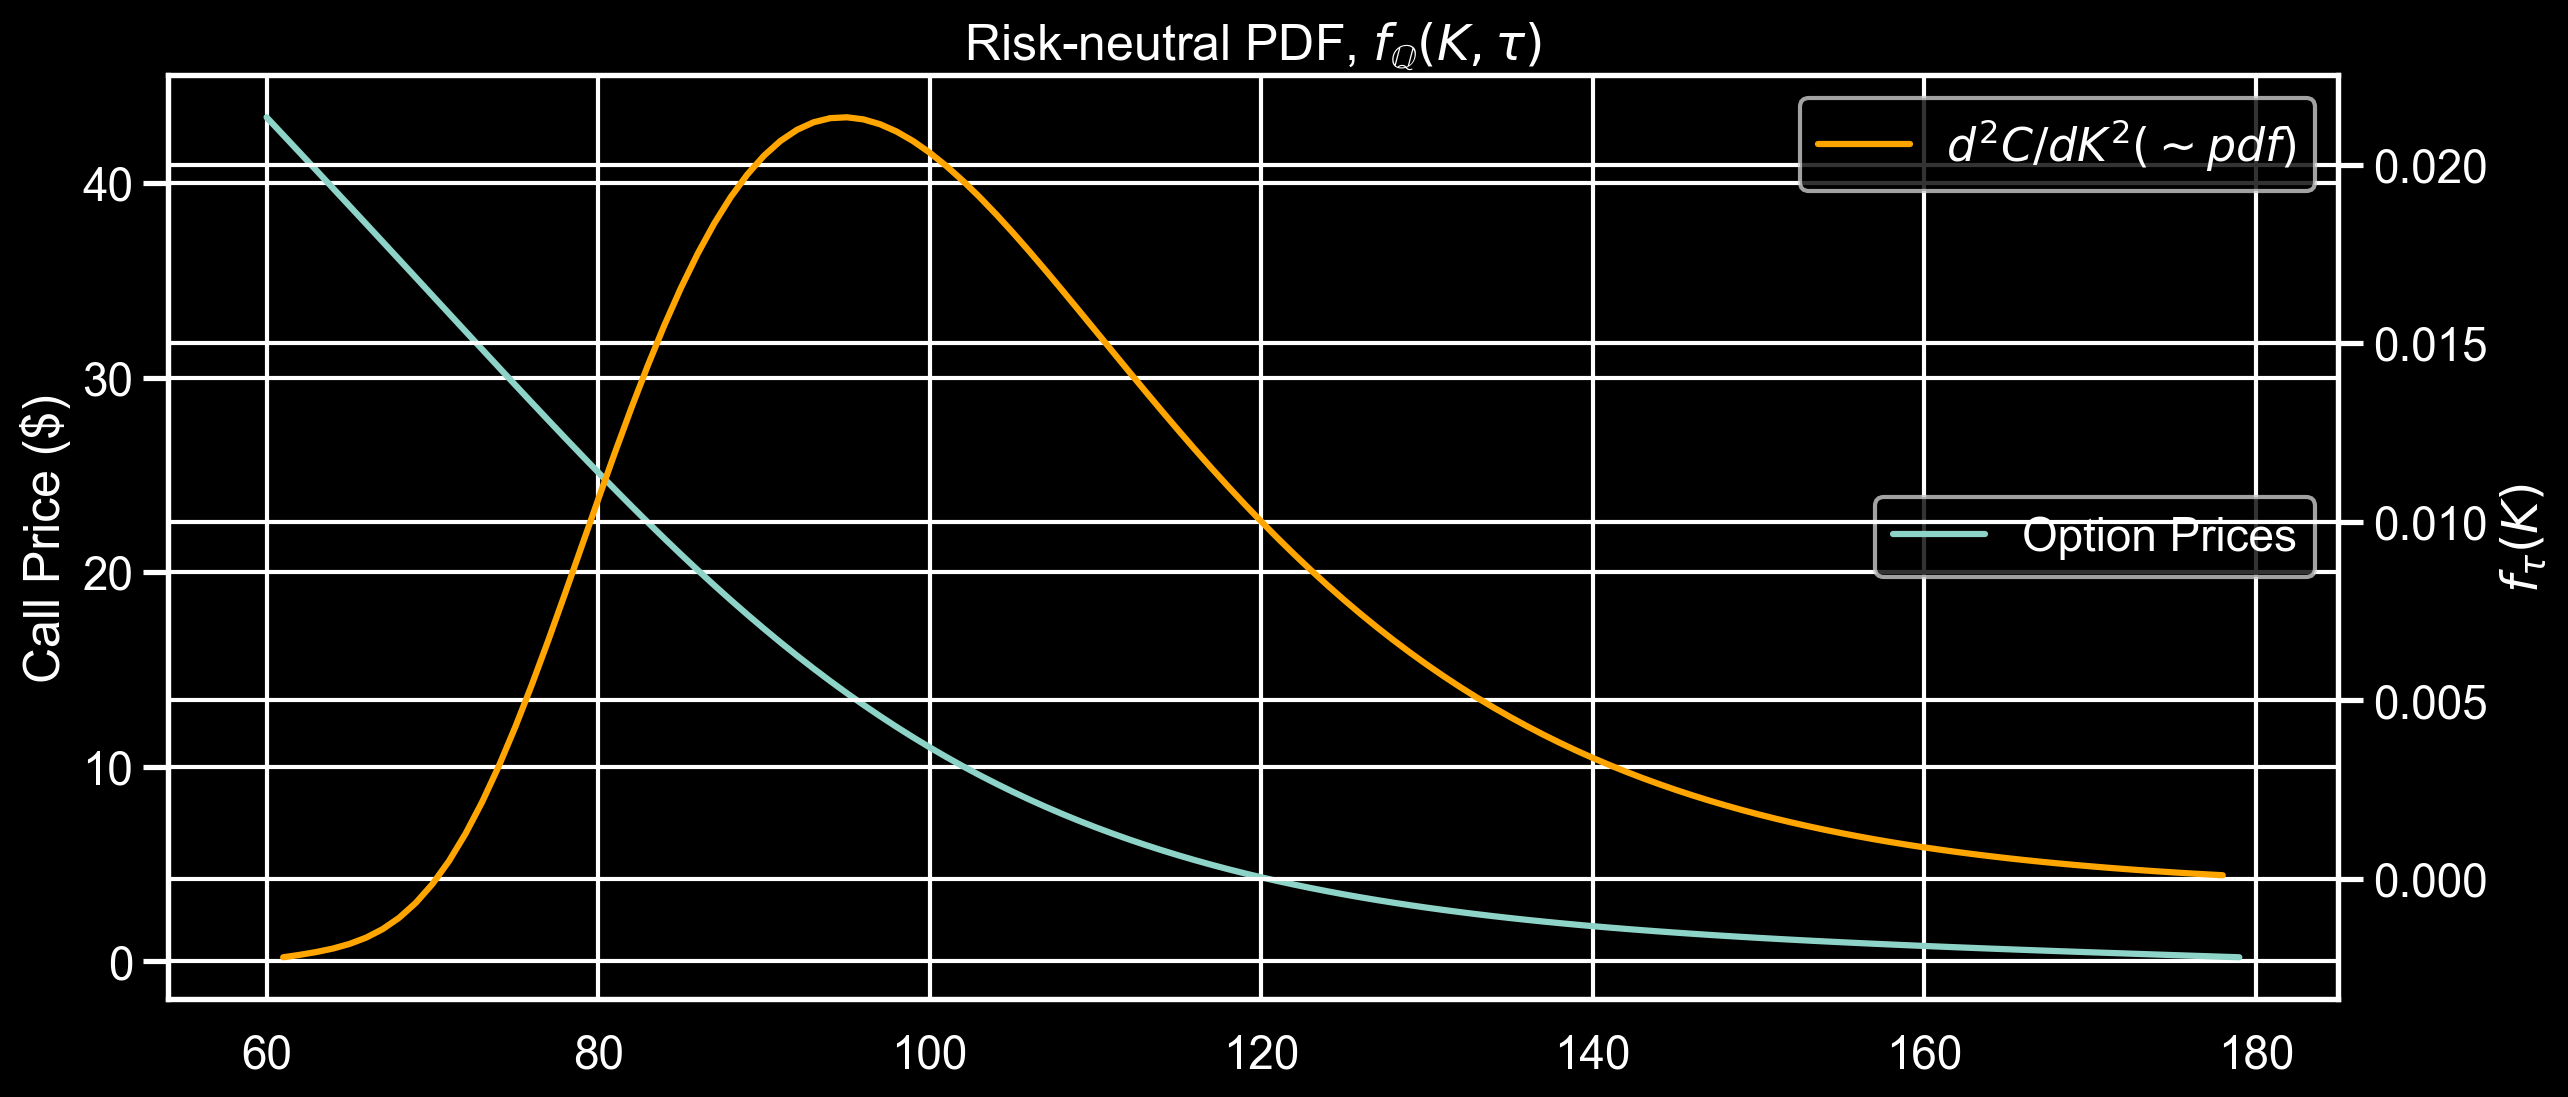

In [8]:
prices = pd.DataFrame([strikes, option_prices]).transpose()
prices.columns = ['strike', 'price']
prices['curvature'] = (-2 * prices['price'] + prices['price'].shift(1) + prices['price'].shift(-1)) / 1**2

# Plotting...

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ylabel('Call Price ($)')
ax2 = ax.twinx()
ax.plot(strikes, option_prices, label='Option Prices')
ax2.plot(prices['strike'], prices['curvature'], label='$d^2C/dK^2 (\sim pdf)$', color='orange')
ax.legend(loc="center right")
ax2.legend(loc="upper right")
plt.xlabel('Strikes (K)')
plt.ylabel('$f_\\tau(K)$')
plt.title('Risk-neutral PDF, $f_\mathbb{Q}(K, \\tau)$')

Let’s compare with QuantLib Heston Model

In [9]:
import QuantLib as ql
today = ql.Date(12, 9, 2023)
expiry_date = today + ql.Period(int(365*tau), ql.Days)

In [10]:
#Settign up Discount Curve

risk_free_curve = ql.FlatForward(today, r, ql.Actual365Fixed())
flat_curve = ql.FlatForward(today, 0.0, ql.Actual365Fixed())
riskfree_ts = ql.YieldTermStructureHandle(risk_free_curve)
dividend_ts = ql.YieldTermStructureHandle(flat_curve)

In [11]:
#Setting up a Heston Model

heston_process = ql.HestonProcess(riskfree_ts, dividend_ts, ql.QuoteHandle(ql.SimpleQuote(S0)), v0, kappa, theta, sigma, rho)
heston_model = ql.HestonModel(heston_process)
heston_handle = ql.HestonModelHandle(heston_model)
heston_vol_surface = ql.HestonBlackVolSurface(heston_handle)


In [12]:
# Now doing some pricing and curvature calculations


vols = [heston_vol_surface.blackVol(tau, x) for x in strikes]
option_prices1 = []
for strike in strikes:
    option = ql.EuropeanOption( ql.PlainVanillaPayoff(ql.Option.Call, strike), ql.EuropeanExercise(expiry_date))
    heston_engine = ql.AnalyticHestonEngine(heston_model)
    option.setPricingEngine(heston_engine)
    option_prices1.append(option.NPV())
prices = pd.DataFrame([strikes, option_prices, option_prices1]).transpose()
prices.columns = ['strike', 'Rectangular Int','QuantLib']
prices['curvature'] = (-2 * prices['QuantLib'] + prices['QuantLib'].shift(1) + prices['QuantLib'].shift(-1)) / 1**2


Text(0.5, 1.0, 'QuantLib: Risk-neutral PDF, $f_\\mathbb{Q}(K, \\tau)$')

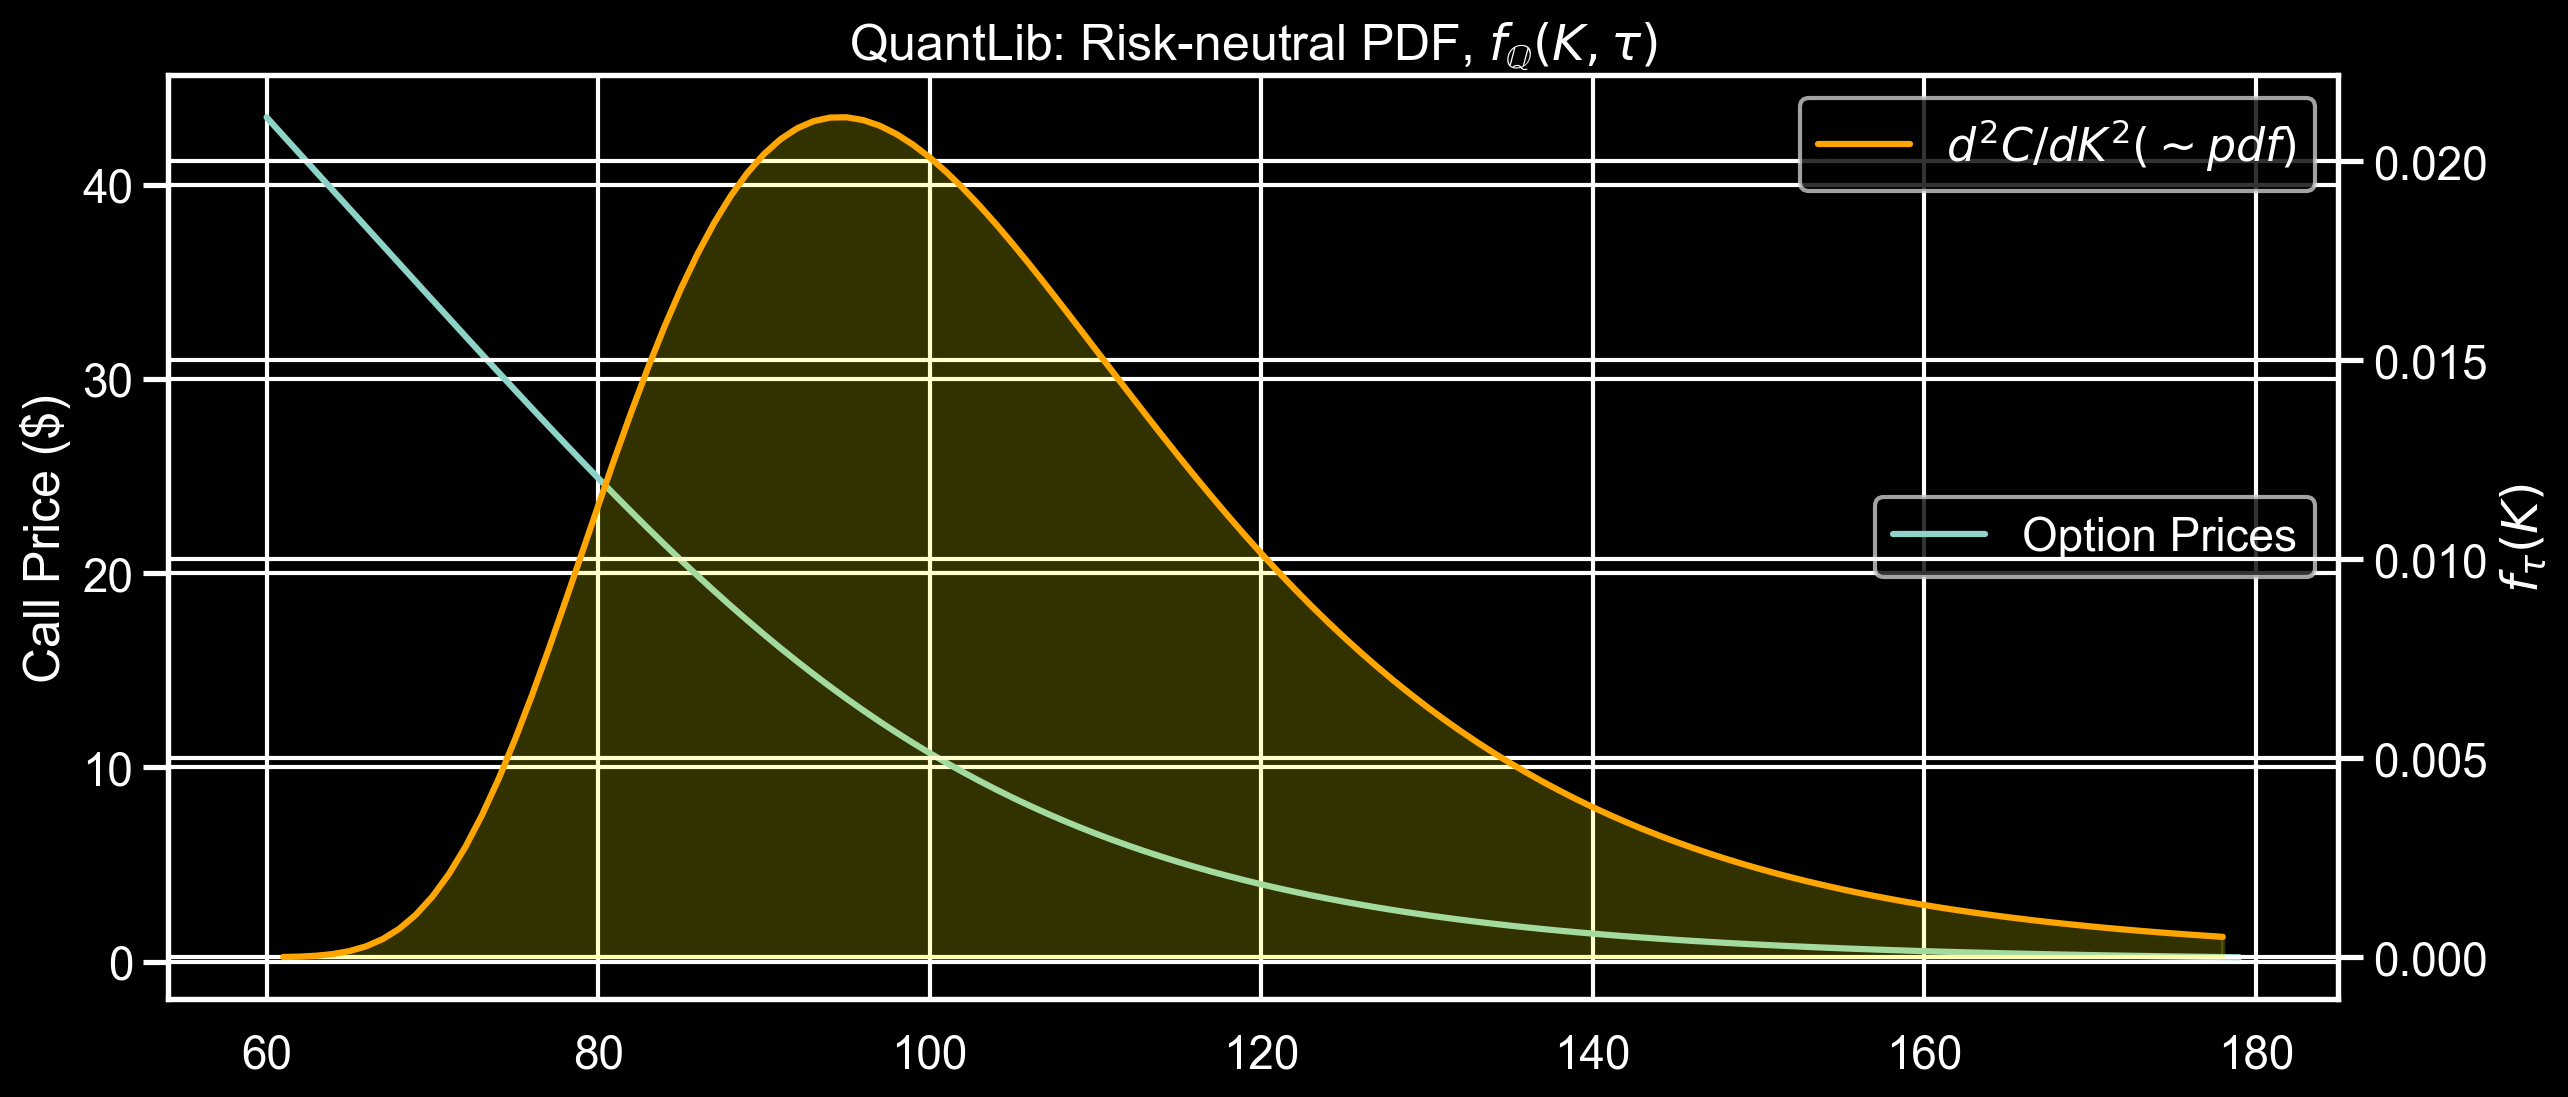

In [13]:
# And plotting...


fig = plt.figure()
ax = fig.add_subplot(111)
plt.ylabel('Call Price ($)')
ax2 = ax.twinx()
ax.plot(strikes, option_prices1, label='Option Prices')
ax2.plot(prices['strike'], prices['curvature'], label='$d^2C/dK^2 (\sim pdf)$', color='orange')
ax2.fill_between(prices['strike'], prices['curvature'], color='yellow', alpha=0.2)

# added these three lines

# ax.legend(loc="center right")
# ax2.legend(loc="upper right")

ax.legend(loc="center right")
ax2.legend(loc="upper right")
plt.xlabel('Strikes (K)')
plt.ylabel('$f_\\tau(K)$')
plt.title('QuantLib: Risk-neutral PDF, $f_\mathbb{Q}(K, \\tau)$')

In [14]:
mse = np.mean( (option_prices - option_prices1)**2 )
print("QuantLib vs. Our Rect Int \n   Mean Squared Error: ", mse)
prices.dropna()
prices.head()

QuantLib vs. Our Rect Int 
   Mean Squared Error:  0.07222755594221887


,strike,Rectangular Int,QuantLib,curvature
0,60.0,43.381100,43.494129,NaN
1,61.0,42.473709,42.552367,0.000007
2,62.0,41.564129,41.610613,0.000017
3,63.0,40.652428,40.668875,0.000039
4,64.0,39.738685,39.727176,0.000082


Interpolation of the Risk-Neutral density function

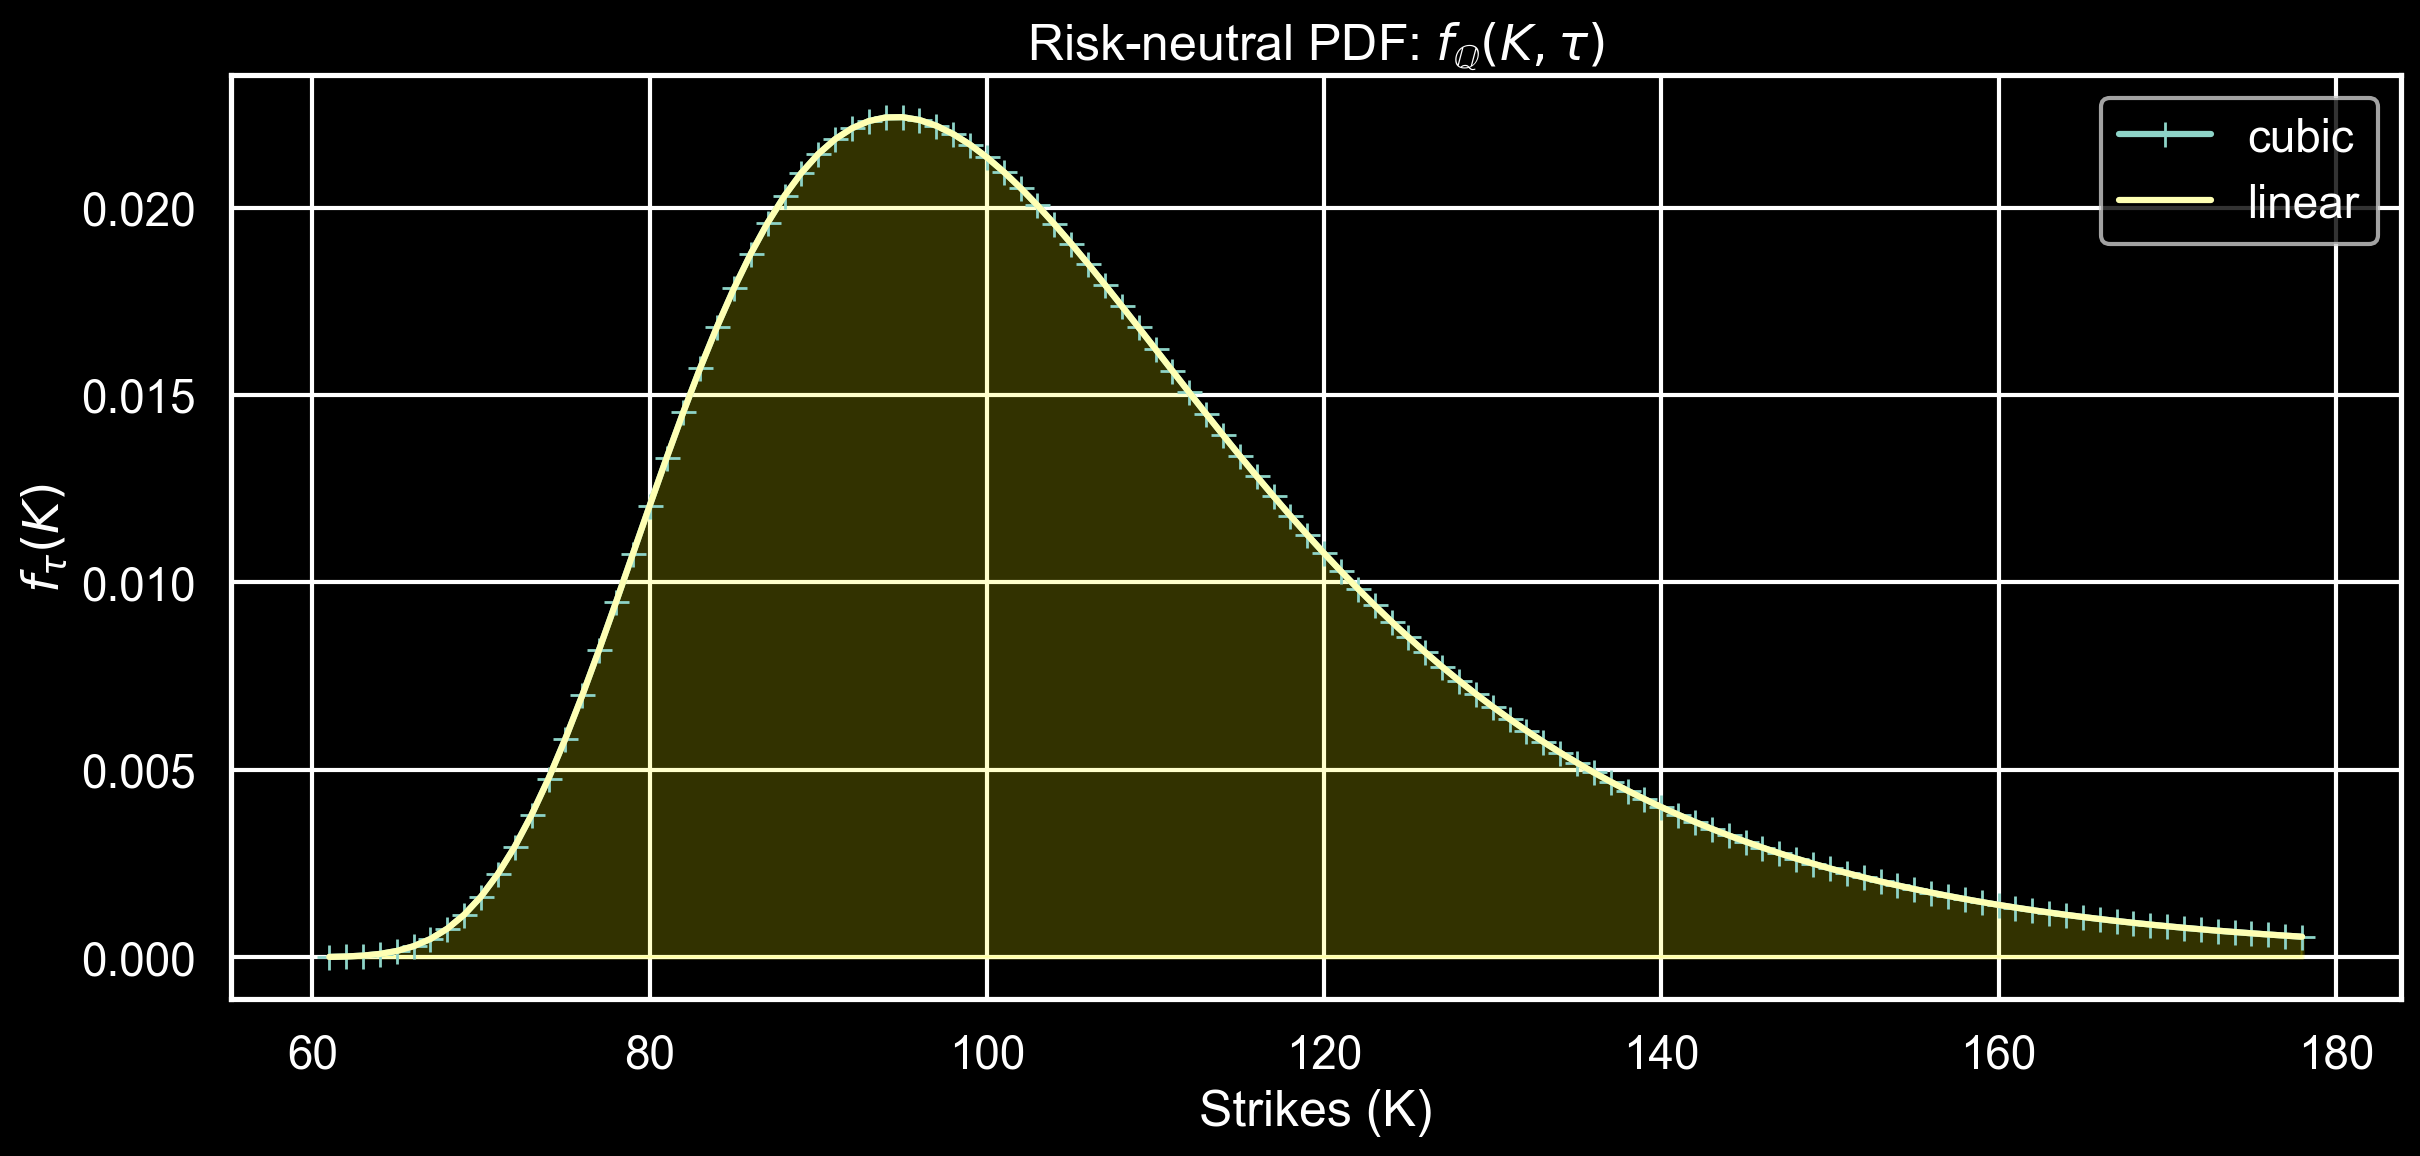

In [24]:
inter = prices.dropna()
pdf = sc.interpolate.interp1d(inter.strike, np.exp(r*tau)*inter.curvature, kind = 'linear')
pdfc = sc.interpolate.interp1d(inter.strike, np.exp(r*tau)*inter.curvature, kind = 'cubic')
strikes = np.arange(61, 179, 1.0)
plt.plot(strikes, pdfc(strikes), '-+', label='cubic')
plt.plot(strikes, pdf(strikes), label='linear')
plt.fill_between(strikes, pdf(strikes), color='yellow', alpha=0.2)
plt.xlabel('Strikes (K)')
plt.ylabel('$f_\\tau(K)$')
plt.title('Risk-neutral PDF: $f_\mathbb{Q}(K, \\tau)$')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Risk-Neutral CDF: $F_\\mathbb{Q}(K, \\tau)$')

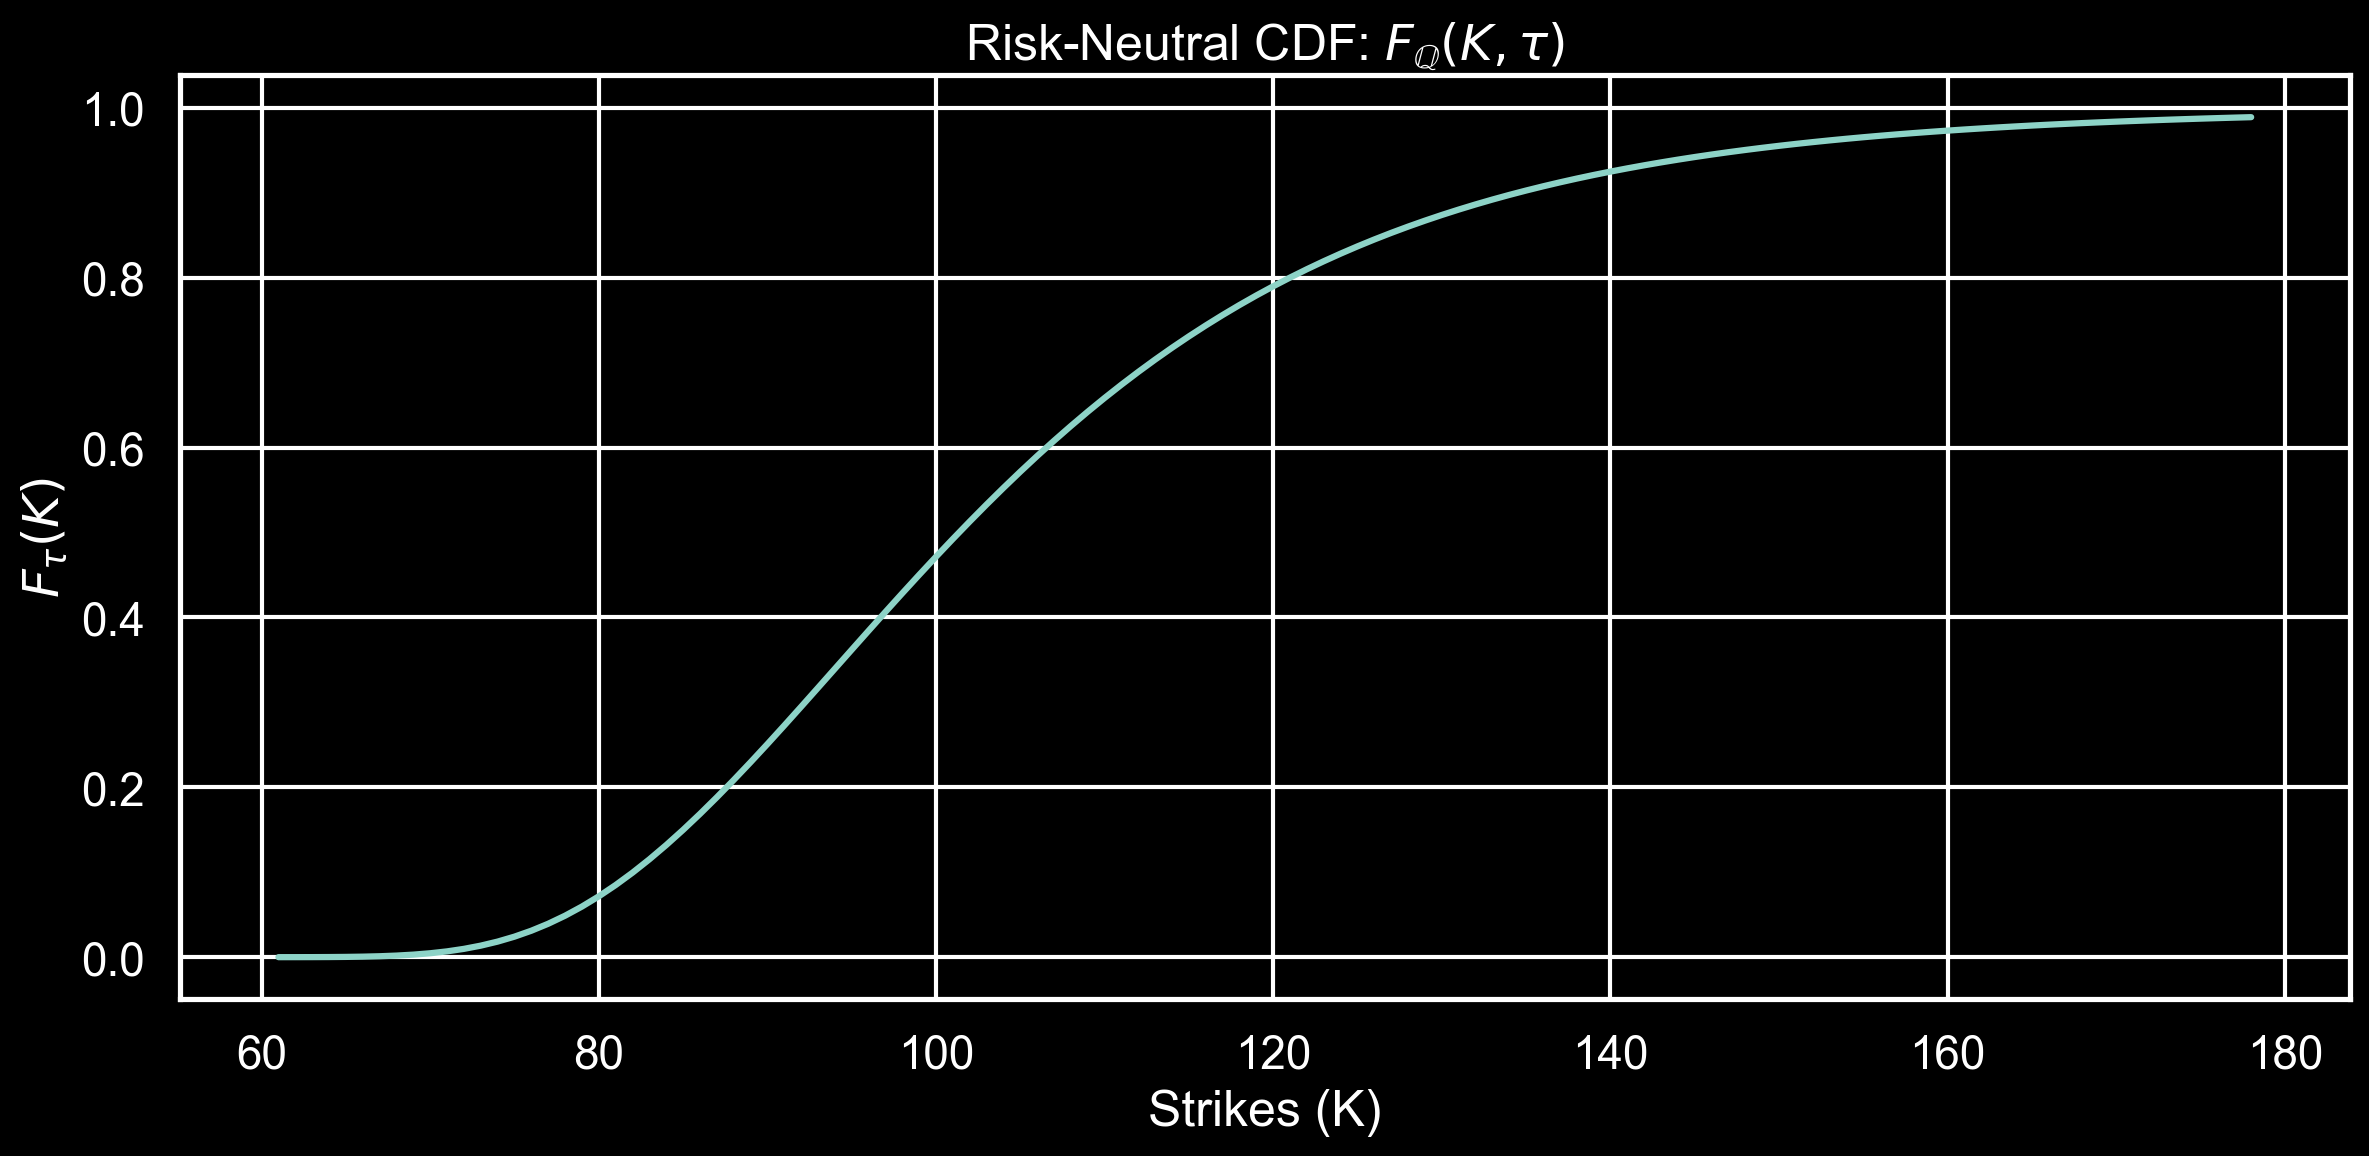

In [25]:
cdf=sc.interpolate.interp1d(inter.strike, np.cumsum(pdf(strikes)), kind= 'linear')

plt.plot(strikes, cdf(strikes))

plt.xlabel('Strikes (K)')
plt.ylabel('$F_\\tau(K)$')
plt.title('Risk-Neutral CDF: $F_\mathbb{Q}(K, \\tau)$')

Using the Risk-neutral PDF to price ‘complex’ derivatives

In [26]:
def integrand_call(x, K):
        return (x-K)*pdf(x)
    
def integrand_put(x, K):
        return (K-x)*pdf(x)
calls, puts = [], []
for K in strikes:
    # integral from K to infinity (looking at CDF, 179 last defined value on range)
    call_int, err = sc.integrate.quad(integrand_call, K, 178, limit=1000, args=K)
    
    # integral from -infinity to K (looking at CDF, 61 lowest defined value on range)
    put_int, err = sc.integrate.quad(integrand_put, 61, K, limit=1000, args=K)
    
    call = np.exp(-r*tau)*call_int
    calls.append( call )
    
    put = np.exp(-r*tau)*put_int
    puts.append( put )
rnd_prices = pd.DataFrame([strikes, calls, puts]).transpose()
rnd_prices.columns = ['strike', 'Calls','Puts']
rnd_prices.tail()

C:\Users\aaron\AppData\Local\Temp\ipykernel_35204\2397578238.py:9: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  call_int, err = sc.integrate.quad(integrand_call, K, 178, limit=1000, args=K)
C:\Users\aaron\AppData\Local\Temp\ipykernel_35204\2397578238.py:12: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  put_int, err = sc.integrate.quad(integrand_put, 61, K, limit=1000, args=K)


,strike,Calls,Puts
113,174.0,0.004409,64.141695
114,175.0,0.002437,65.070985
115,176.0,0.001064,66.000836
116,177.0,0.000261,66.931232
117,178.0,0.000000,67.862238
